# Calculo del cociente espectral HV

In [28]:
import obspy  
import numpy as np
from scipy.signal import windows
import matplotlib.pyplot as plt


## Lectura del archivo de parámetros

Se carga un archivo de texto con los paramatros requeridos para el procesamiento.


| Parámetro | Valor de ejemplo | Descripción |
|------------|------------------|--------------|
| **Duración LTA** | `25` | Longitud de la ventana LTA (*Long-Term Average*), usada para calcular el promedio a largo plazo de la señal. |
| **Duración STA** | `2` | Longitud de la ventana STA (*Short-Term Average*), usada para calcular el promedio a corto plazo. |
| **Umbral mínimo STA/LTA (bajo)** | `0.2` | Umbral mínimo del cociente STA/LTA para detectar el inicio de un evento. |
| **Umbral mínimo STA/LTA (alto)** | `2` | Segundo valor de umbral STA/LTA; puede representar una condición superior o alternativa de detección. |
| **Duración mínima de ventana seleccionada** | `32` | Duración mínima (en segundos o muestras) de las ventanas válidas para el análisis. |
| **Tipo de ventana** | `0` | Define si las ventanas son de **longitud fija (0)** o **variable (1)**. |
| **Duración máxima (si variable)** | `40` | Longitud máxima permitida para ventanas de longitud variable. |
| **Porcentaje de solapamiento entre ventanas** | `0` | Porcentaje de recubrimiento entre ventanas consecutivas. `0` significa que no hay solapamiento. |
| **Tipo de suavizado espectral (FFT)** | `1` | Tipo de suavizado aplicado al espectro antes del cálculo H/V. `1` indica suavizado **Konno-Ohmachi**. |
| **Parámetro b del suavizado Konno-Ohmachi** | `40` | Controla el grado de suavizado: valores mayores producen un suavizado más estrecho. |
| **Criterio de selección de ventanas** | `1` | `0`: selección independiente por componente. `1`: selección basada en la media cuadrática de las tres componentes. |
| **Frecuencia de corte del sensor (Hz)** | `0.5` | Frecuencia de corte o límite inferior de respuesta del sensor. |
| **Factor de decimación de los datos** | `1` | Indica el grado de reducción de muestreo. `1` significa que no hay decimación. |
| **Frecuencia máxima de salida (Hz)** | `30` | Frecuencia máxima considerada o guardada en el archivo de salida. |

In [ ]:
lta = 25.0   # Length (s) for the Long-Term Average (LTA)
sta = 2.0    # Length (s) for the Short-Term Average (STA)
seuilmin = 0.2  # Minimum threshold for the STA/LTA ratio
seuilmax = 2.0  # Maximum threshold for the STA/LTA ratio
tmin = 32.0     # Minimum window length to select (s)
tmax = 40.0     # Maximum window length (if variable lengths are used)
tvar = 0.0      # Time window for the trigger (s)
overlap = 0.0   # Percentage of overlap between two consecutive windows
trig_var = 1    # Select windows simultaneously on the 3 components (0) or on the RMS of the 3 components (1)

## Lectura de los archivos de datos sísmicos

Extrae los nombres de los archivos que se usaran para el análisis y define la carpeta de destino de los resultados.

In [ ]:
data_E = obspy.read("00P2-2_WA.WAU40..HHE.D.2020.281.sac", format="SAC")[0].data # east-west component
data_N = obspy.read("00P2-2_WA.WAU40..HHN.D.2020.281.sac", format="SAC")[0].data # north-south component
data_Z = obspy.read("00P2-2_WA.WAU40..HHZ.D.2020.281.sac", format="SAC")[0].data # vertical component
data_times = obspy.read("00P2-2_WA.WAU40..HHE.D.2020.281.sac", format="SAC")[0].times() # in seconds
data = np.column_stack((data_Z, data_N, data_E)) # combine the three components into a single array
fs = 1 / (data_times[1] - data_times[0]) # sampling frequency

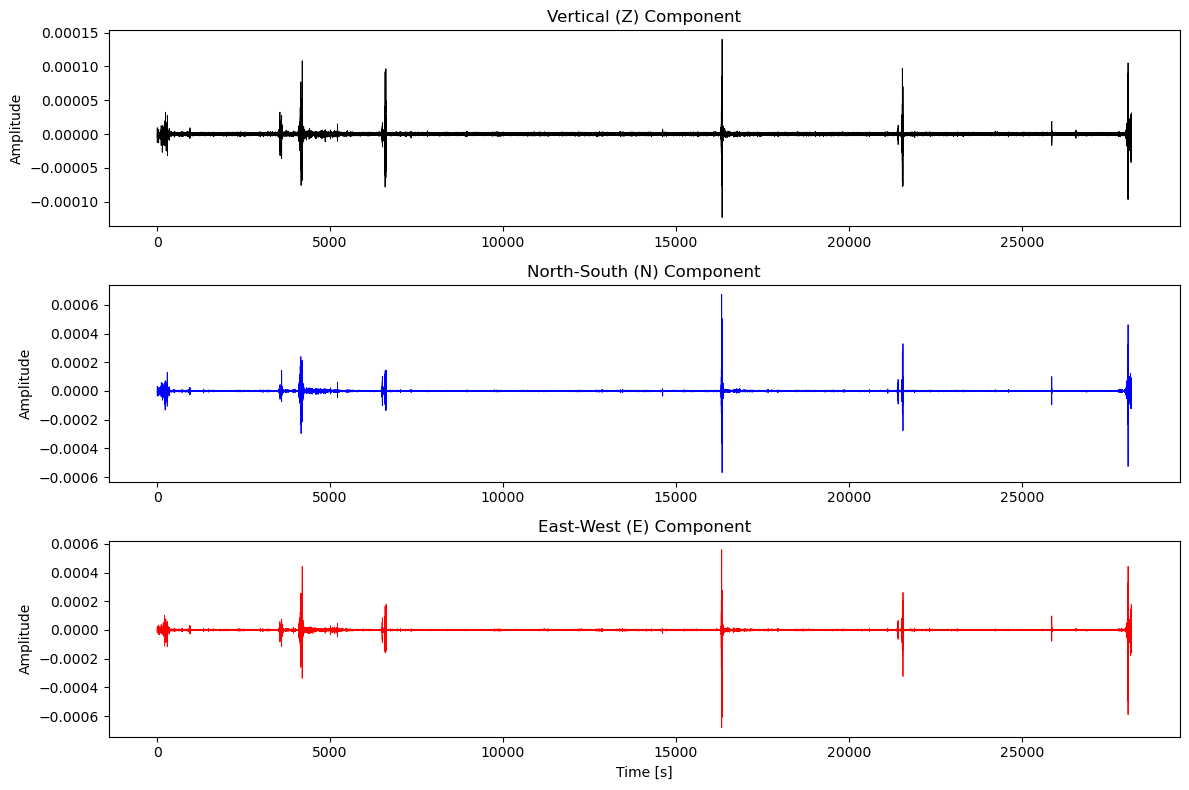

In [30]:
# --- Plot the three components ---
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(data_times, data_Z, color='black', linewidth=0.6)
plt.title("Vertical (Z) Component")
plt.ylabel("Amplitude")

plt.subplot(3, 1, 2)
plt.plot(data_times, data_N, color='blue', linewidth=0.6)
plt.title("North-South (N) Component")
plt.ylabel("Amplitude")

plt.subplot(3, 1, 3)
plt.plot(data_times, data_E, color='red', linewidth=0.6)
plt.title("East-West (E) Component")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()

## Bucle principal: procesamiento de cada conjunto de registros (N–S, E–O, Z)

### Selección de ventanas estacionarias 

Identifica ventanas de señal estacionaria (sin eventos transitorios) en los registros sísmicos o de vibraciones. El método se basa en el cálculo de los promedios móviles STA/LTA (Short-Term Average / Long-Term Average), una técnica clásica de detección de eventos en señales sísmicas. 

**STA**

Mide la energía instantánea o de corto plazo de la señal dentro de una ventana pequeña.

**LTA**

Calcula el nivel promedio de energía de la señal en una ventana mucho más larga.

En este contexto la energía es:

$$
E = \frac{1}{N} \sum_{i=1}^{N} s_i^2
$$

donde: $ s_i $ son los valores de la señal en la ventana y $ N $ es el número de muestras en la ventana.
 

Se define el cociente STA/LTA como:

$$
R(t) = \frac{\text{STA}(t)}{\text{LTA}(t)}
$$

Cuando no hay evento sísmico, STA y LTA son similares, por lo tanto:

$$
R(t) \approx 1
$$

Cuando llega un evento (por ejemplo, una onda sísmica), la energía a corto plazo aumenta, por lo que:

$$
R(t) \gg 1
$$

En este caso, el método STA/LTA se utiliza para seleccionar automáticamente las ventanas de la señal que contienen movimiento significativo, es decir, aquellas partes útiles para calcular el cociente espectral H/V y descartar los intervalos dominados solo por ruido.


Parámetros ajustables del método:

- Duración STA
- Duración LTA
- Umbral mínimo STA/LTA (bajo)
- Umbral mínimo STA/LTA (alto)



In [ ]:
def calculta(sig, nwin, mean_val, i0):
    """
    Compute a moving average over 'nwin' samples.
    Equivalent to the MATLAB calculta function.
    """
    filt = np.ones(nwin) / nwin
    res = np.convolve(sig, filt, mode='same')
    # avoid division by zero
    res[res == 0] = mean_val
    return res

def trigger(data, lta, sta, lta_sta_min, lta_sta_max, Fs, 
            tmin, tmax, tvar, overlap, trig_var):
    """
    Translation of MATLAB trigger.m by J. Régnier (2009)
    for selecting stationary noise windows in H/V analysis.
    """

    nt, nbsens = data.shape
    dt = 1.0 / Fs
    t = np.arange(dt, dt * (nt + 1), dt)

    nlta = int(round(lta * Fs))  # number of points for LTA
    nsta = int(round(sta * Fs))  # number of points for STA
    nmin = int(tmin * Fs)
    nmax = int(tmax * Fs)
    teste = np.ones(nt, dtype=bool)

    # I. Apodization (Hanning taper on 2%)
    data_a = np.zeros_like(data)
    for i in range(nbsens):
        s = data[:, i] - np.mean(data[:, i])
        ws = windows.hann(len(s))
        nw = int(0.02 * len(s))
        s[:nw] *= ws[:nw]
        s[-nw:] *= ws[-nw:]
        data_a[:, i] = s

    # II. Average amplitude (RMS of 3 components)
    datamoy = np.sqrt(np.sum(data_a**2, axis=1))
    datamoymoy = np.mean(datamoy)
    maxim2 = np.max(datamoy)

    # II. Compute LTA and STA
    if trig_var == 0:
        lta_sta = np.zeros((nbsens, nt))
        for i in range(nbsens):
            sigmoy = np.abs(data_a[:, i])
            maxim = np.max(sigmoy)
            LTA = calculta(sigmoy, nlta, datamoymoy, nlta+1)
            STA = calculta(sigmoy, nsta, datamoymoy, nlta+1)
            ratio = STA / LTA
            lta_sta[i, :] = ratio
            teste &= (ratio > lta_sta_min) & (ratio < lta_sta_max) & (sigmoy < maxim * 0.99)
    else:
        LTA = calculta(datamoy, nlta, datamoymoy, nlta+1)
        STA = calculta(datamoy, nsta, datamoymoy, nlta+1)
        lta_sta = STA / LTA
        teste &= (lta_sta > lta_sta_min) & (lta_sta < lta_sta_max) & (datamoy < maxim2 * 0.99)

    # III. Select windows that satisfy STA/LTA constraints
    nbwin = 0
    fen = []

    io = 0
    if tvar == 0:
        nmax = nmin

    while (io + nmax - 1) < len(data):
        z = True
        iinit = io
        ifinal = io + nmax
        nlongmax = nmin

        # shrink window if invalid region found
        while not np.all(teste[iinit:ifinal]):
            ifinal -= 1
            if (ifinal - iinit) < nmin:
                z = False
                break

        if z:
            fen.append([iinit, ifinal])
            nbwin += 1
            noverlap = int(round(overlap / 100 * (ifinal - iinit)))
            io += (ifinal - iinit - noverlap)
        else:
            noverlap = int(round(overlap / 100 * (ifinal - iinit)))
            W = np.where(~teste[iinit:ifinal+1])[0]
            if len(W) > 0:
                io += W[-1] + 1
            else:
                io += nmin

    fen = np.array(fen).T if len(fen) > 0 else np.empty((2, 0), dtype=int)

    return fen, datamoy, lta_sta


In [25]:
fen, datamoy, lta_sta = trigger(
    data=data,
    lta=25.0,
    sta=2.0,
    lta_sta_min=0.2,
    lta_sta_max=2.0,
    Fs=100.0,
    tmin=32.0,
    tmax=40.0,
    tvar=0.0,
    overlap=0.0,
    trig_var=1
)

Selecting stationary noise windows...


### Cálculo de espectros H/V, determinación del pico $𝑓_{0}$, criterios SESAME y visualización